In [12]:
import pandas as pd
import numpy as np

import os
import sys
from IPython.display import Audio


import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

print ("Done")


Done


In [13]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)
len(ravdess_directory_list)


['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


24

In [14]:
file_emotion = []
file_path = []

for i in ravdess_directory_list:
    actor = os.listdir(ravdess + i)
    for f in actor:
        full_path = os.path.join(ravdess + i, f)
        
        if os.path.isfile(full_path):
            part = f.split('.')[0].split('-')
            
            if len(part) > 2:
                file_emotion.append(int(part[2]))
                file_path.append(full_path)
            else:
                print(f"Skipping file due to unexpected structure: {f}")


In [15]:
print(part[0])
print(int(part[2]))
print(file_path[0])
print(f)


03
5
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
03-01-05-02-01-02-07.wav


In [16]:
keep = ['sad', 'happy', 'angry', 'fear', 'surprise']


In [17]:
# ---------- 1. создаём датафрейм ----------
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])   # ещё числа 1‑8
path_df    = pd.DataFrame(file_path,   columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# ---------- 2. переводим коды в строки ----------
code2label = {1:'neutral',
              2:'calm',
              3:'happy',
              4:'sad',
              5:'angry',
              6:'fear',
              7:'disgust',
              8:'surprise'}

ravdess_df['Emotions'] = ravdess_df['Emotions'].map(code2label)

# ---------- 3. удаляем всё, кроме пяти нужных ----------
keep = ['sad', 'happy', 'angry', 'fear', 'surprise']   # только эти остаются
ravdess_df = ravdess_df[ravdess_df['Emotions'].isin(keep)].reset_index(drop=True)

# ---------- 4. проверяем ----------
print(ravdess_df['Emotions'].value_counts())
print("_______________________________________________")
print(ravdess_df.head())


Emotions
surprise    192
fear        192
sad         192
happy       192
angry       192
Name: count, dtype: int64
_______________________________________________
   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1      fear  /kaggle/input/ravdess-emotional-speech-audio/a...
2       sad  /kaggle/input/ravdess-emotional-speech-audio/a...
3     happy  /kaggle/input/ravdess-emotional-speech-audio/a...
4     angry  /kaggle/input/ravdess-emotional-speech-audio/a...


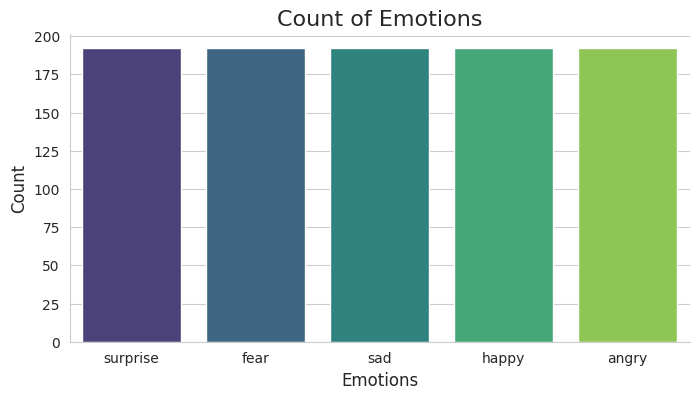

In [18]:
sns.set_style('whitegrid')

plt.figure(figsize=(8, 4))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=ravdess_df, order=ravdess_df.Emotions.value_counts().index, palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [19]:
y, sr = librosa.load(file_path[0])
print(f'y: {y[50000:50010]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00637961 -0.00639314 -0.00608352 -0.00414876 -0.00297462 -0.00214042
 -0.00155214 -0.00181125  0.00087566  0.006554  ]
shape y: (77988,)
sr: 22050


In [20]:
Audio(file_path[0], autoplay=True)


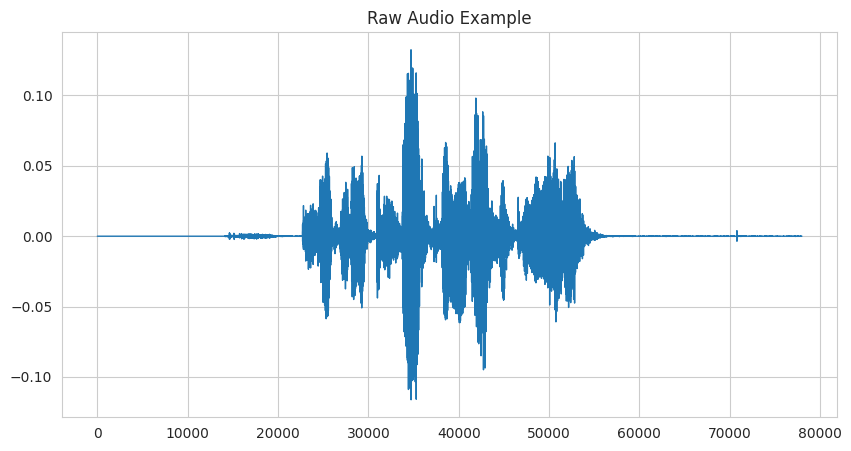

In [21]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example'
                 )
plt.show()

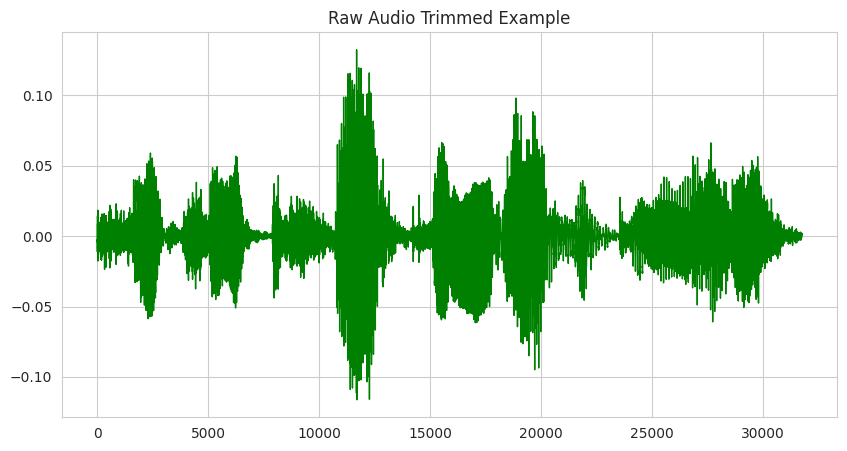

In [22]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color='green')
plt.show()


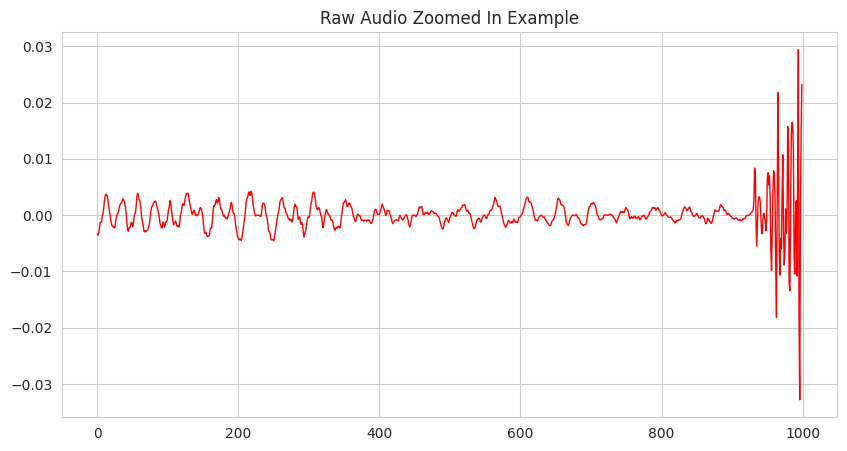

In [23]:
pd.Series(y[30000:31000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color='red')
plt.show()


In [24]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape


(1025, 153)

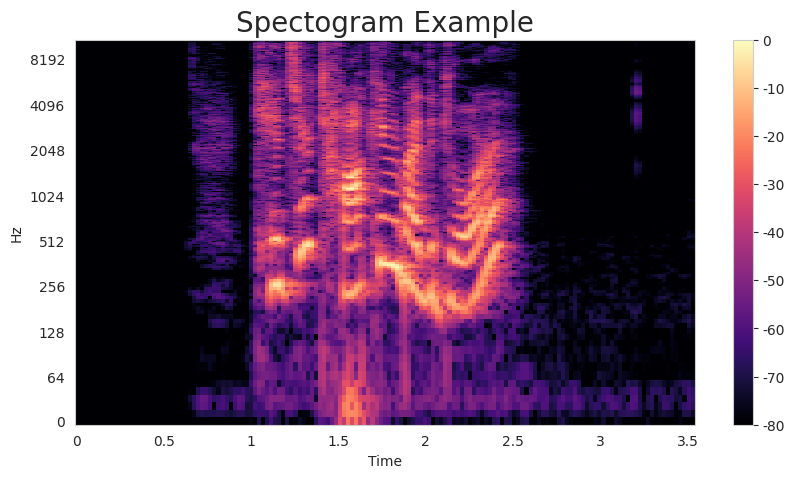

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.0f')
plt.show()


In [26]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,
                                  )
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)


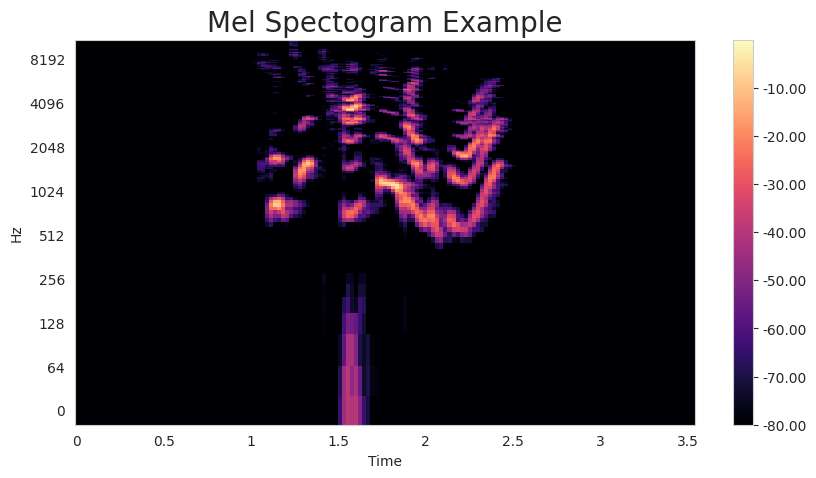

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()


In [28]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [29]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path    = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    code = file.split('_')[2]

    if   code == 'SAD': file_emotion.append('sad')
    elif code == 'ANG': file_emotion.append('angry')
    elif code == 'DIS': file_emotion.append('disgust')
    elif code == 'FEA': file_emotion.append('fear')
    elif code == 'HAP': file_emotion.append('happy')
    elif code == 'NEU': file_emotion.append('neutral')
    else:               file_emotion.append('Unknown')

# -------------------- создаём датафрейм --------------------
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df    = pd.DataFrame(file_path,    columns=['Path'])
Crema_df   = pd.concat([emotion_df, path_df], axis=1)

# -------------------- смотрим баланс до фильтра --------------------
print("До фильтра:\n", Crema_df['Emotions'].value_counts(), "\n")

# -------------------- фильтруем только нужные метки --------------------
keep = ['sad', 'happy', 'angry', 'fear', 'surprise']   # нужные пять
Crema_df = Crema_df[Crema_df['Emotions'].isin(keep)].reset_index(drop=True)

# -------------------- баланс после фильтра --------------------
print("После фильтра:\n", Crema_df['Emotions'].value_counts())
Crema_df.head()

До фильтра:
 Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64 

После фильтра:
 Emotions
happy    1271
sad      1271
fear     1271
angry    1271
Name: count, dtype: int64


,Emotions,Path
0,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
1,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
2,happy,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav
3,sad,/kaggle/input/cremad/AudioWAV/1023_TIE_SAD_XX.wav
4,sad,/kaggle/input/cremad/AudioWAV/1004_WSI_SAD_XX.wav


In [30]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df  = Tess_df[Tess_df['Emotions'].isin(keep)].reset_index(drop=True)

Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [31]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df = Savee_df[Savee_df['Emotions'].isin(keep)].reset_index(drop=True)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
happy       60
fear        60
angry       60
surprise    60
sad         60
Name: count, dtype: int64


In [32]:
data_path = pd.concat([ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,fear,/kaggle/input/ravdess-emotional-speech-audio/a...
2,sad,/kaggle/input/ravdess-emotional-speech-audio/a...
3,happy,/kaggle/input/ravdess-emotional-speech-audio/a...
4,angry,/kaggle/input/ravdess-emotional-speech-audio/a...


In [33]:
data_path.Emotions.value_counts()


Emotions
surprise    192
fear        192
sad         192
happy       192
angry       192
Name: count, dtype: int64

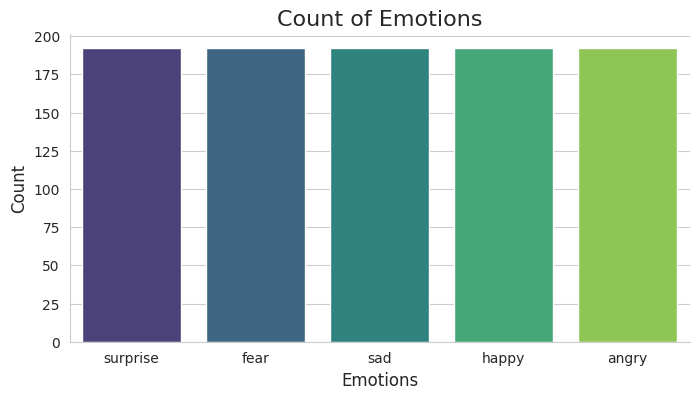

In [34]:
sns.set_style('whitegrid')

plt.figure(figsize=(8, 4))

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path, order=data_path.Emotions.value_counts().index, palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [35]:
data, sr = librosa.load(file_path[0])
sr


22050

In [36]:
Audio(file_path[0], autoplay=True)


In [37]:
def pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
    

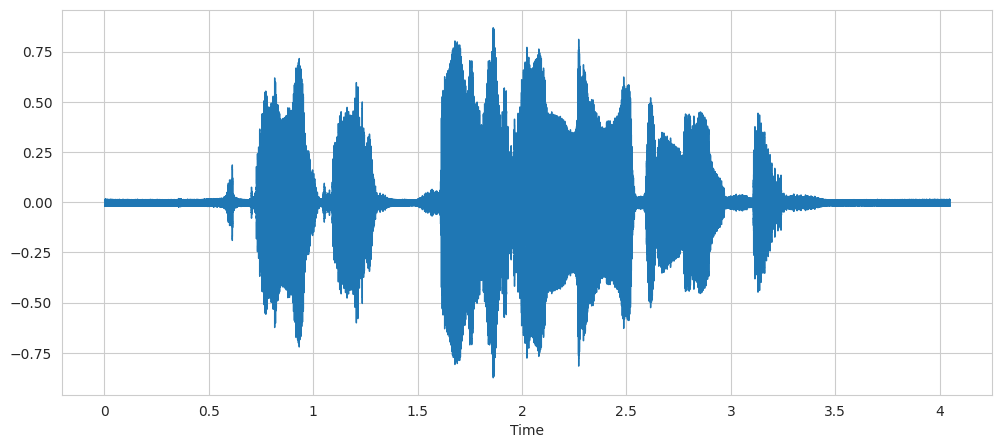

In [38]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
Audio(data, rate=sr)


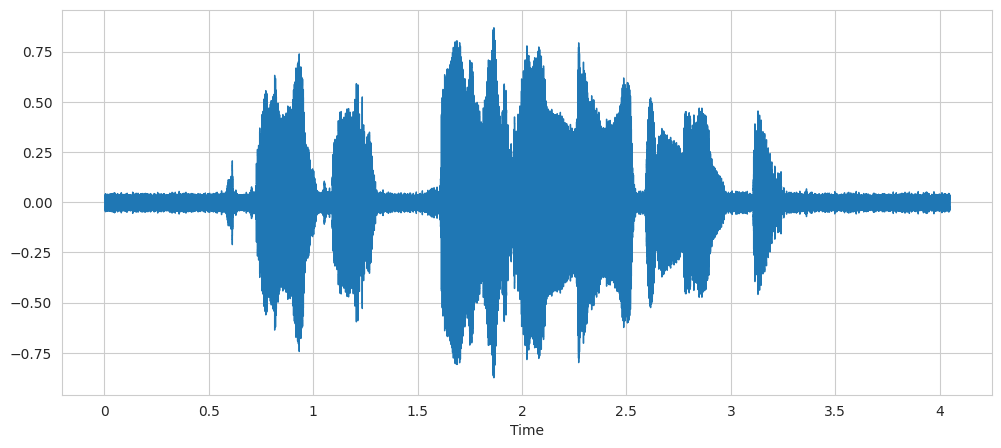

In [39]:
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)


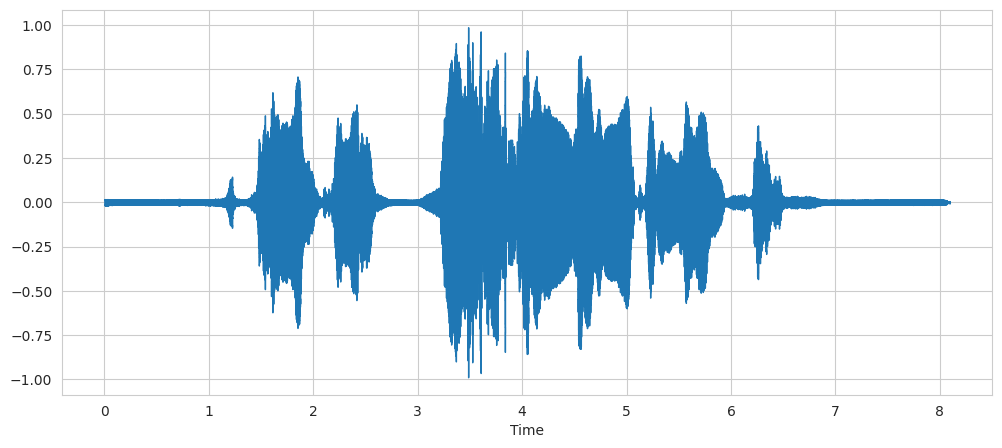

In [40]:
x = stretch(data, rate=0.5)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)


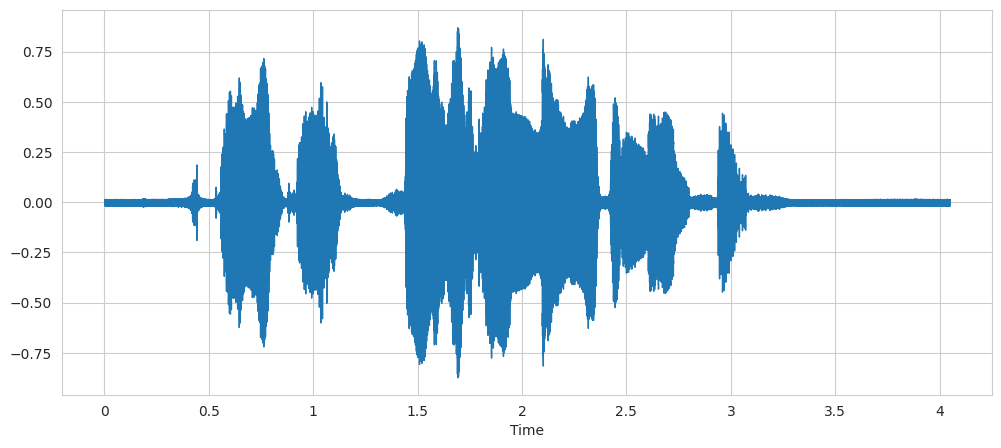

In [41]:
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)


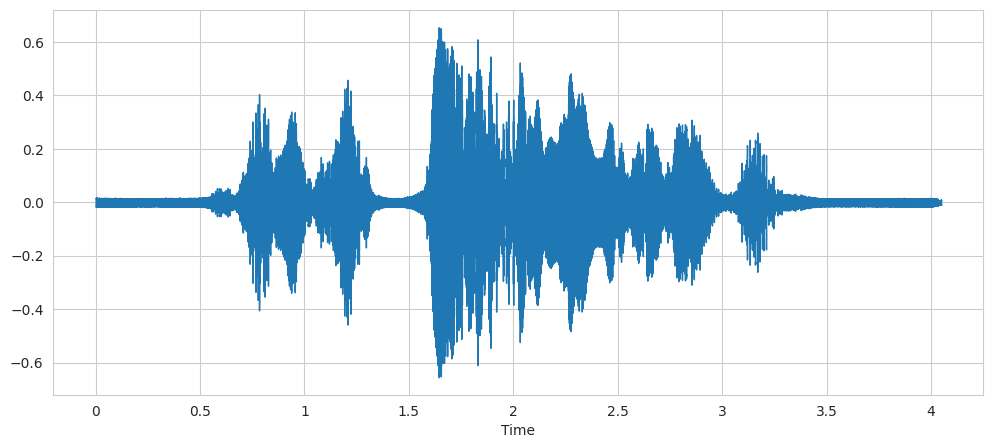

In [42]:
x = pitch(data, sr, n_steps=-5)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
Audio(x, rate=sr)


In [43]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    stft_data = np.abs(librosa.stft(data, n_fft=frame_length, hop_length=hop_length))

    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length).squeeze()

    rmse = librosa.feature.rms(S=stft_data).squeeze()

    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)

    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), sr=sr, n_mfcc=13).T.ravel()

    return np.hstack([zcr, rmse, mfcc])

def augment_and_extract(data, sr, frame_length=2048, hop_length=512):
    augments = [data, data + 0.005 * np.random.normal(0, 1, len(data)),  # Original + noise
                librosa.effects.pitch_shift(data, sr=sr, n_steps=2),      # Pitched
                librosa.effects.pitch_shift(data + 0.005 * np.random.normal(0, 1, len(data)), sr=sr, n_steps=2)]  # Pitched + noise
    return np.vstack([extract_features(aug, sr, frame_length, hop_length) for aug in augments])

def get_features(path, duration=2.5, offset=0.6, sr=22050, frame_length=2048, hop_length=512):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    return augment_and_extract(data, sr, frame_length, hop_length)



In [44]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())


Number of processors:  4


In [45]:
from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)


Time:  48.30256316799995


In [46]:
len(X), len(Y), data_path.Path.shape


(3840, 3840, (960,))

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()


In [48]:
print(Emotions.isna().sum())


0            0
1            0
2            0
3            0
4            0
            ..
1616        44
1617        44
1618        44
1619        44
Emotions     0
Length: 1621, dtype: int64


In [49]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().sum().sum())


0


In [50]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values


In [51]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((3072, 1620), (3072, 5), (768, 1620), (768, 5))

In [53]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [54]:
x_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)


In [56]:
from tensorflow.keras.regularizers import l2


In [57]:
model = tf.keras.Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),

    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.25),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1620, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 810, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 810, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 405, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 405, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,301 (1.92 MB)

 Trainable params: 503,301 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=128)


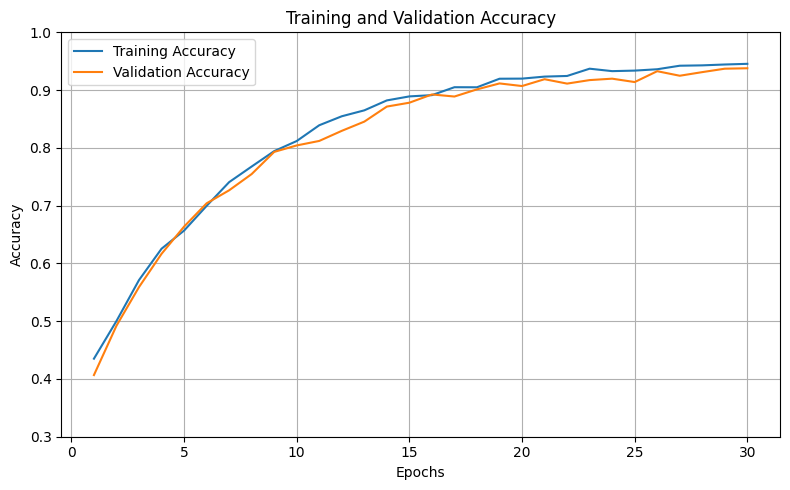

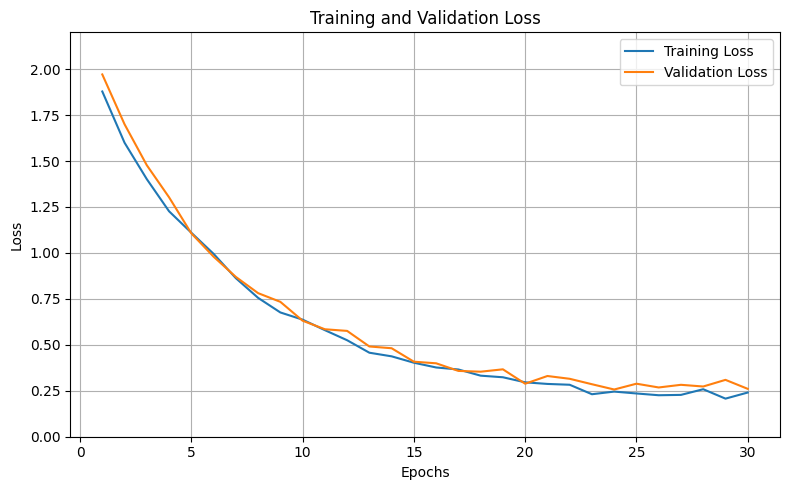

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
model.save('emotion_recognition_model.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Предсказание вероятностей
y_pred_probs = model.predict(x_test)  # x_test — входные данные
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=['sadness', 'surprise', 'fear', 'anger', 'joy']))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Classification Report (Test Set):
              precision    recall  f1-score   support

     sadness       0.93      0.91      0.92       138
    surprise       0.91      0.90      0.90       156
        fear       0.94      0.92      0.93       152
       anger       0.92      0.93      0.93       164
         joy       0.90      0.93      0.92       158

    accuracy                           0.92       768
   macro avg       0.92      0.92      0.92       768
weighted avg       0.92      0.92      0.92       768



In [ ]:
import pickle
pickle.dump(scaler,  open("scaler.pkl",  "wb"))
pickle.dump(encoder, open("encoder.pkl", "wb"))


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('emotion_recognition_model.h5')
